In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf
from data_loader import get_tf_datasets
from models import StampClassifier16
from models import StampClassifierMultiScale, StampClassifierFull
from hp_search import balanced_xentropy
tf.__version__

2025-02-07 08:19:28.181164: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-07 08:19:28.181204: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-07 08:19:28.181243: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-07 08:19:28.190574: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-07 08:19:29.221580: W tensorflow/compiler/

'2.14.0'

In [3]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import det_curve, DetCurveDisplay
from itertools import product

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, datetime

In [5]:
normalized_ndarrays = pd.read_pickle('../data/normalized_ndarrays.pkl')
normalized_ndarrays

{'x_train': array([[[[ 1.31218404e-01,  2.08908409e-01, -1.01644576e-01,
            0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
          [ 2.04099461e-01,  2.16877177e-01, -3.88860777e-02,
            0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
          [ 1.58876970e-01,  2.10590184e-01, -3.21848430e-02,
            0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
          ...,
          [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
            1.00000000e+00,  1.00000000e+00,  1.00000000e+00],
          [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
            1.00000000e+00,  1.00000000e+00,  1.00000000e+00],
          [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
            1.00000000e+00,  1.00000000e+00,  1.00000000e+00]],
 
         [[ 1.27886310e-01,  1.91338807e-01, -1.43070519e-02,
            0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
          [ 1.99795172e-01,  1.99528217e-01,  5.73620424e-02,
            0.00000000e+00,  0.000

In [6]:
LabelEncoder = normalized_ndarrays['label_encoder']
del normalized_ndarrays

In [7]:
LabelEncoder

LabelEncoder()

In [8]:
N_CLASSES = 6
BATCH_SIZE = 64
LABELS = [
    'agn',
    'asteroid',
    'bogus',
    'satellite',
    'sn',
    'vs'
]

In [9]:
os.environ["CUDA_VISIBLE_DEVICES"] = 'MIG-802fb5a9-d98a-5bce-ad53-9227189dc2cf'

In [10]:
def evaluate_dataset(classifier, dataset):
    y_list = []
    predicted_probs_list = []
    images = []
    for X, pos, y in dataset:
        predicted_probs = tf.nn.softmax(classifier((X, pos)))
        y = y.numpy()
        y_list.append(y)
        predicted_probs_list.append(predicted_probs.numpy())
        images.append(X.numpy())
    predicted_probs = np.concatenate(predicted_probs_list, axis=0)
    y = np.concatenate(y_list, axis=0)
    predictions = tf.argmax(predicted_probs, axis=1).numpy()
    return y, predicted_probs, predictions, images


In [46]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd

dataset_name = 'full'
BATCH_SIZE = 32  # Ajusta según tu configuración

all_conf_matrices = []
all_class_reports = []

for i in range(5):  # Para las 5 corridas
    with tf.device('/cpu:0'):
        training_dataset, testidation_dataset, test_dataset, label_encoder = get_tf_datasets(
            dataset_name=dataset_name, batch_size=BATCH_SIZE)
        
        # Cargar el modelo entrenado para la corrida i
        stamp_classifier = tf.keras.models.load_model(f'{dataset_name}_run_{i}/')

        # Obtener predicciones
        y_test, test_predicted_probs, test_predictions, images_test = evaluate_dataset(stamp_classifier, test_dataset)

        y_test_labels = LabelEncoder.inverse_transform(y_test)
        test_predictions_labels = LabelEncoder.inverse_transform(test_predictions)

        # Calcular la matriz de confusión
        conf_matrix = confusion_matrix(y_test_labels, test_predictions_labels, labels=LabelEncoder.classes_, normalize='true')
        all_conf_matrices.append(conf_matrix)

        # Calcular el classification report
        report = classification_report(y_test_labels, test_predictions_labels, output_dict=True)
        all_class_reports.append(report)

x_train.shape final (29586, 63, 63, 6)


2025-02-07 08:45:07.693133: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:933] Skipping loop optimization for Merge node with control input: StatefulPartitionedCall/rot90_1/Assert/AssertGuard/branch_executed/_47
2025-02-07 08:45:17.099597: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:933] Skipping loop optimization for Merge node with control input: StatefulPartitionedCall/rot90/Assert/AssertGuard/branch_executed/_28


x_train.shape final (29586, 63, 63, 6)


2025-02-07 08:45:27.915272: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:933] Skipping loop optimization for Merge node with control input: StatefulPartitionedCall/rot90_1/Assert/AssertGuard/branch_executed/_47
2025-02-07 08:45:37.455950: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:933] Skipping loop optimization for Merge node with control input: StatefulPartitionedCall/rot90/Assert/AssertGuard/branch_executed/_28


x_train.shape final (29586, 63, 63, 6)


2025-02-07 08:45:48.455451: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:933] Skipping loop optimization for Merge node with control input: StatefulPartitionedCall/rot90/Assert/AssertGuard/branch_executed/_28
2025-02-07 08:45:58.709934: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:933] Skipping loop optimization for Merge node with control input: StatefulPartitionedCall/rot90_2/Assert/AssertGuard/branch_executed/_66


x_train.shape final (29586, 63, 63, 6)


2025-02-07 08:46:09.647878: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:933] Skipping loop optimization for Merge node with control input: StatefulPartitionedCall/rot90/Assert/AssertGuard/branch_executed/_28
2025-02-07 08:46:19.297467: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:933] Skipping loop optimization for Merge node with control input: StatefulPartitionedCall/rot90_2/Assert/AssertGuard/branch_executed/_66


x_train.shape final (29586, 63, 63, 6)


2025-02-07 08:46:30.328997: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:933] Skipping loop optimization for Merge node with control input: StatefulPartitionedCall/rot90/Assert/AssertGuard/branch_executed/_28
2025-02-07 08:46:39.882421: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:933] Skipping loop optimization for Merge node with control input: StatefulPartitionedCall/rot90/Assert/AssertGuard/branch_executed/_28


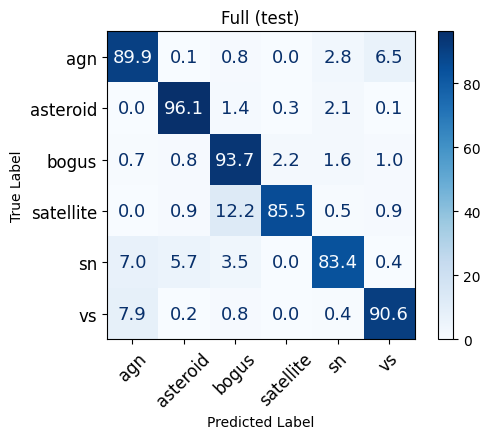

In [47]:
mean_conf_matrix = np.mean(all_conf_matrices, axis=0) * 100

# **2. Graficar la matriz de confusión promedio**
fig, ax = plt.subplots(figsize=(6, 4))
disp = ConfusionMatrixDisplay(confusion_matrix=mean_conf_matrix, display_labels=LabelEncoder.classes_,)
disp.plot(ax=ax, cmap="Blues", values_format=".1f")

# Ajustes de etiquetas y títulos
plt.xticks(rotation=45, fontsize=12)  # Rotar el eje X
plt.yticks(fontsize=12)  # Aumentar el tamaño en el eje Y
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Full (test)")

# Ajuste del tamaño del texto dentro de la matriz
for text in ax.texts:
    text.set_fontsize(13)  # Aumentar tamaño de los valores en la matriz
plt.show()

In [48]:
# **3. Calcular la media y desviación estándar del classification report**
labels = list(all_class_reports[0].keys())[:-3]  # Excluye 'accuracy', 'macro avg' y 'weighted avg'
metrics = ['precision', 'recall', 'f1-score']

# Crear DataFrame para almacenar resultados
report_df = pd.DataFrame(index=labels, columns=[f'{m}_mean' for m in metrics] + [f'{m}_std' for m in metrics])

# Calcular media y desviación estándar para cada métrica
for label in labels:
    for metric in metrics:
        values = [rep[label][metric] for rep in all_class_reports]
        report_df.at[label, f'{metric}_mean'] = np.mean(values)
        report_df.at[label, f'{metric}_std'] = np.std(values)

report_df*100

,precision_mean,recall_mean,f1-score_mean,precision_std,recall_std,f1-score_std
agn,88.256097,89.861893,89.007405,1.656826,2.374724,0.467948
asteroid,96.060681,96.132898,96.087161,1.120774,0.87282,0.302013
bogus,96.860641,93.661442,95.228873,0.77325,0.674499,0.137129
satellite,56.773107,85.517241,68.203369,1.941374,1.758283,1.167883
sn,79.911031,83.374827,81.479969,3.595583,3.073404,1.01127
vs,91.932329,90.636631,91.235554,1.86019,2.23289,0.441488


In [49]:
# Extraer las métricas macro promedio y su desviación estándar
macro_metrics = ['macro avg']  # Puedes agregar 'weighted avg' si lo necesitas

# Crear DataFrame para los macro promedios
macro_report_df = pd.DataFrame(index=macro_metrics, columns=[f'{m}_mean' for m in ['precision', 'recall', 'f1-score']] +
                                                            [f'{m}_std' for m in ['precision', 'recall', 'f1-score']])

# Calcular media y desviación estándar para los macros
for metric in ['precision', 'recall', 'f1-score']:
    values = [rep['macro avg'][metric] for rep in all_class_reports]
    macro_report_df.at['macro avg', f'{metric}_mean'] = np.mean(values) * 100
    macro_report_df.at['macro avg', f'{metric}_std'] = np.std(values) * 100

macro_report_df

,precision_mean,recall_mean,f1-score_mean,precision_std,recall_std,f1-score_std
macro avg,84.965648,89.864155,86.873722,0.582039,0.193717,0.313883


In [50]:
print('******* Test Set *******')
print(f"F1: {macro_report_df[f'f1-score_mean'].values[0]:.2f} ± {macro_report_df[f'f1-score_std'].values[0]:.2f}") 
print(f"Precision: {macro_report_df[f'precision_mean'].values[0]:.2f} ± {macro_report_df[f'precision_std'].values[0]:.2f}") 
print(f"Recall: {macro_report_df[f'recall_mean'].values[0]:.2f} ± {macro_report_df[f'recall_std'].values[0]:.2f}") 
print('************************')

******* Test Set *******
F1: 86.87 ± 0.31
Precision: 84.97 ± 0.58
Recall: 89.86 ± 0.19
************************


In [51]:
f1_test_paper = 86.68
prec_test_paper = 84.34
recall_test_paper = 90.48

In [52]:
macro_report_df[f'f1-score_mean'].values[0] - f1_test_paper

0.19372195662717218

In [38]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd

dataset_name = 'full'
BATCH_SIZE = 32  # Ajusta según tu configuración

all_conf_matrices = []
all_class_reports = []

for i in range(5):  # Para las 5 corridas
    with tf.device('/cpu:0'):
        training_dataset, validation_dataset, test_dataset, label_encoder = get_tf_datasets(
            dataset_name=dataset_name, batch_size=BATCH_SIZE)
        
        # Cargar el modelo entrenado para la corrida i
        stamp_classifier = tf.keras.models.load_model(f'{dataset_name}_run_{i}/')

        # Obtener predicciones
        y_val, val_predicted_probs, val_predictions, images_val = evaluate_dataset(stamp_classifier, validation_dataset)

        y_val_labels = LabelEncoder.inverse_transform(y_val)
        val_predictions_labels = LabelEncoder.inverse_transform(val_predictions)

        # Calcular la matriz de confusión
        conf_matrix = confusion_matrix(y_val_labels, val_predictions_labels, labels=LabelEncoder.classes_, normalize='true')
        all_conf_matrices.append(conf_matrix)

        # Calcular el classification report
        report = classification_report(y_val_labels, val_predictions_labels, output_dict=True)
        all_class_reports.append(report)

x_train.shape final (29586, 63, 63, 6)


2025-02-07 08:41:31.357988: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:933] Skipping loop optimization for Merge node with control input: StatefulPartitionedCall/rot90/Assert/AssertGuard/branch_executed/_28
2025-02-07 08:41:41.030626: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:933] Skipping loop optimization for Merge node with control input: StatefulPartitionedCall/rot90/Assert/AssertGuard/branch_executed/_28


x_train.shape final (29586, 63, 63, 6)


2025-02-07 08:41:52.047254: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:933] Skipping loop optimization for Merge node with control input: StatefulPartitionedCall/rot90/Assert/AssertGuard/branch_executed/_28
2025-02-07 08:42:01.458283: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:933] Skipping loop optimization for Merge node with control input: StatefulPartitionedCall/rot90_1/Assert/AssertGuard/branch_executed/_47


x_train.shape final (29586, 63, 63, 6)


2025-02-07 08:42:12.153323: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:933] Skipping loop optimization for Merge node with control input: StatefulPartitionedCall/rot90_2/Assert/AssertGuard/branch_executed/_66
2025-02-07 08:42:21.494043: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:933] Skipping loop optimization for Merge node with control input: StatefulPartitionedCall/rot90_1/Assert/AssertGuard/branch_executed/_47


x_train.shape final (29586, 63, 63, 6)


2025-02-07 08:42:32.456927: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:933] Skipping loop optimization for Merge node with control input: StatefulPartitionedCall/rot90/Assert/AssertGuard/branch_executed/_28
2025-02-07 08:42:41.868318: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:933] Skipping loop optimization for Merge node with control input: StatefulPartitionedCall/rot90/Assert/AssertGuard/branch_executed/_28


x_train.shape final (29586, 63, 63, 6)


2025-02-07 08:42:52.767949: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:933] Skipping loop optimization for Merge node with control input: StatefulPartitionedCall/rot90/Assert/AssertGuard/branch_executed/_28
2025-02-07 08:43:02.335785: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:933] Skipping loop optimization for Merge node with control input: StatefulPartitionedCall/rot90/Assert/AssertGuard/branch_executed/_28


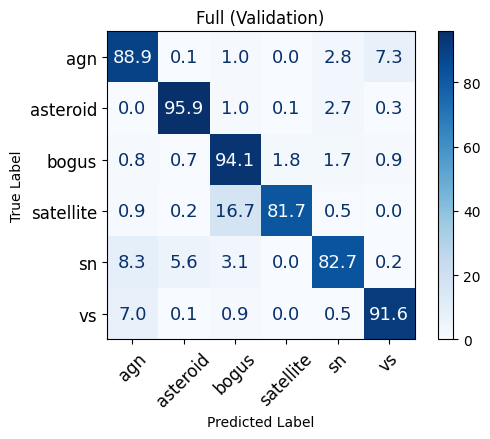

In [45]:
mean_conf_matrix = np.mean(all_conf_matrices, axis=0) * 100

# **2. Graficar la matriz de confusión promedio**
fig, ax = plt.subplots(figsize=(6, 4))
disp = ConfusionMatrixDisplay(confusion_matrix=mean_conf_matrix, display_labels=LabelEncoder.classes_,)
disp.plot(ax=ax, cmap="Blues", values_format=".1f")

# Ajustes de etiquetas y títulos
plt.xticks(rotation=45, fontsize=12)  # Rotar el eje X
plt.yticks(fontsize=12)  # Aumentar el tamaño en el eje Y
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Full (Validation)")

# Ajuste del tamaño del texto dentro de la matriz
for text in ax.texts:
    text.set_fontsize(13)  # Aumentar tamaño de los valores en la matriz
plt.show()

In [40]:
# **3. Calcular la media y desviación estándar del classification report**
labels = list(all_class_reports[0].keys())[:-3]  # Excluye 'accuracy', 'macro avg' y 'weighted avg'
metrics = ['precision', 'recall', 'f1-score']

# Crear DataFrame para almacenar resultados
report_df = pd.DataFrame(index=labels, columns=[f'{m}_mean' for m in metrics] + [f'{m}_std' for m in metrics])

# Calcular media y desviación estándar para cada métrica
for label in labels:
    for metric in metrics:
        values = [rep[label][metric] for rep in all_class_reports]
        report_df.at[label, f'{metric}_mean'] = np.mean(values)
        report_df.at[label, f'{metric}_std'] = np.std(values)

report_df*100

,precision_mean,recall_mean,f1-score_mean,precision_std,recall_std,f1-score_std
agn,88.270347,88.890026,88.545391,1.268922,2.239778,0.558263
asteroid,96.461751,95.893246,96.167177,0.698752,1.376865,0.540942
bogus,96.868027,94.087774,95.452292,0.765394,0.704765,0.166169
satellite,61.871745,81.724138,70.31949,2.09429,4.021346,0.987691
sn,78.379359,82.710927,80.36352,3.885095,2.547356,1.231768
vs,91.360904,91.576885,91.43387,1.795535,1.807045,0.224377


In [42]:
# Extraer las métricas macro promedio y su desviación estándar
macro_metrics = ['macro avg']  # Puedes agregar 'weighted avg' si lo necesitas

# Crear DataFrame para los macro promedios
macro_report_df = pd.DataFrame(index=macro_metrics, columns=[f'{m}_mean' for m in ['precision', 'recall', 'f1-score']] +
                                                            [f'{m}_std' for m in ['precision', 'recall', 'f1-score']])

# Calcular media y desviación estándar para los macros
for metric in ['precision', 'recall', 'f1-score']:
    values = [rep['macro avg'][metric] for rep in all_class_reports]
    macro_report_df.at['macro avg', f'{metric}_mean'] = np.mean(values) * 100
    macro_report_df.at['macro avg', f'{metric}_std'] = np.std(values) * 100

macro_report_df

,precision_mean,recall_mean,f1-score_mean,precision_std,recall_std,f1-score_std
macro avg,85.535356,89.147166,87.046957,0.512067,0.593025,0.254697


In [43]:
print('******* Validation Set *******')
print(f"F1: {macro_report_df[f'f1-score_mean'].values[0]:.2f} ± {macro_report_df[f'f1-score_std'].values[0]:.2f}") 
print(f"Precision: {macro_report_df[f'precision_mean'].values[0]:.2f} ± {macro_report_df[f'precision_std'].values[0]:.2f}") 
print(f"Recall: {macro_report_df[f'recall_mean'].values[0]:.2f} ± {macro_report_df[f'recall_std'].values[0]:.2f}") 
print('************************')

******* Validation Set *******
F1: 87.05 ± 0.25
Precision: 85.54 ± 0.51
Recall: 89.15 ± 0.59
************************


In [ ]:
mean_conf_matrix = np.mean(all_conf_matrices, axis=0)
cm = confusion_matrix(y_true=y_true, y_pred=y_pred, labels=order_classes, normalize='true')

cmap = plt.cm.Blues
fig, ax = plt.subplots(figsize=(figsize, figsize)) #, dpi=110)
im = ax.imshow(np.around(cm, decimals=2), interpolation='nearest', cmap=cmap)

# color map
new_color = cmap(1.0) 

# Añadiendo manualmente las anotaciones con la media y desviación estándar
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        if cm[i, j] >= 0.005:
            #print(cm[i, j])
            text = f'{np.around(cm[i, j], decimals=2)}'
            color = "white" if cm[i, j] > 0.5 else new_color  # Blanco para la diagonal, tono de azul para otras celdas
            ax.text(j, i, text, ha="center", va="center", color=color, fontsize=fs)
        else:
            text = f'{np.around(cm[i, j], decimals=2)}'
            color = "white" if cm[i, j] > 0.5 else new_color  # Blanco para la diagonal, tono de azul para otras celdas
            ax.text(j, i, text, ha="center", va="center", color=color, fontsize=fs)

# Ajustes finales y mostrar la gráfica
ax.tick_params(axis='both', which='major', labelsize=fs)
ax.set_xticks(np.arange(len(order_classes)))
ax.set_yticks(np.arange(len(order_classes)))
ax.set_xticklabels(order_classes)
ax.set_yticklabels(order_classes)
plt.setp(ax.get_xticklabels(), rotation=90, ha="right", rotation_mode="anchor")

ax.set_xlabel('Predicted Label', fontsize=fs+2)
ax.set_ylabel('True Label', fontsize=fs+2)

ax.xaxis.label.set_size(fs+2)
ax.yaxis.label.set_size(fs+2)
ax.xaxis.labelpad = 13
ax.yaxis.labelpad = 13

plt.tight_layout()
plt.savefig(path_save)
plt.close(fig)

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(mean_conf_matrix, annot=True, fmt=".1f", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Mean Confusion Matrix Over 5 Runs")
plt.show()

In [18]:
dataset_name = 'full'
i = 0

with tf.device('/cpu:0'):
    training_dataset, validation_dataset, test_dataset, label_encoder = get_tf_datasets(
        dataset_name=dataset_name, batch_size=BATCH_SIZE)
    #stamp_classifier = tf.keras.models.load_model(f'saved_models/{dataset_name}_run_{i}/')
    stamp_classifier = tf.keras.models.load_model(f'{dataset_name}_run_{i}/')
    y_val, val_predicted_probs, val_predictions, images_val = evaluate_dataset(stamp_classifier, validation_dataset)

print('y_val:', y_val.shape)
print('val_predictions:', val_predictions.shape)

(9862,)

In [14]:
with tf.device('/cpu:0'):
    y_test, test_predicted_probs, test_predictions, images_test = evaluate_dataset(stamp_classifier, test_dataset)

In [ ]:
print('y_test:', y_test.shape)
print('test_predictions:', test_predictions.shape)

In [45]:
for b in validation_dataset:
    print(b)
    break

(<tf.Tensor: shape=(64, 63, 63, 6), dtype=float32, numpy=
array([[[[ 5.55989780e-02,  2.77429610e-01, -3.79745066e-02,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 9.00271088e-02,  2.71785200e-01,  1.48523405e-01,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 6.00318424e-02,  2.72807121e-01,  2.99650021e-02,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         ...,
         [ 6.52558804e-02,  2.78823227e-01,  6.73804358e-02,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 8.78682733e-02,  2.81814069e-01,  2.02923119e-02,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 8.18669274e-02,  2.79148817e-01,  1.14476290e-02,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

        [[ 6.76989928e-02,  2.76165426e-01,  6.55059516e-03,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 2.14817338e-02,  2.77233958e-01, -1.95179328e-01,
    

In [35]:
satellite_cands = images[val_predicted_probs[:, 3] > 0.8]

In [25]:
images = np.concatenate(images, axis=0)
images.shape

(9862, 63, 63, 6)

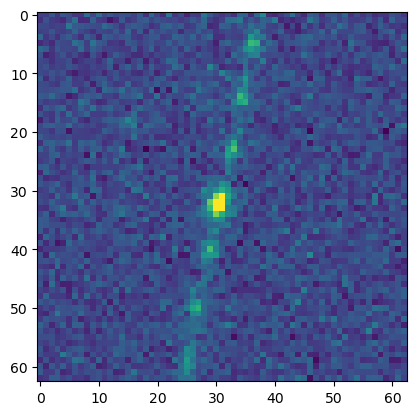

In [44]:
plt.imshow(satellite_cands[8, :, :, 0])